In [1]:
import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import matplotlib.pyplot as plt
import matplotlib
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn as nn
import copy
import torch
from torchvision import transforms
from torch.optim import lr_scheduler
import os
import math
import numpy as np
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from skimage import io
import umap
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Data preparation

In [2]:
def read_image(path) :
        img_dict = {"img_dir" : [], "label" : [], 'label_bin':[]}
        for root, dirs, files in os.walk(path):
            for img in files:
                img_dict["img_dir"].append(os.path.join(root, img))
                
                img_dict["label"].append(img[:4])
                if img[:4] != 'real':
                    img_dict["label_bin"].append(0.0)
                else:
                    img_dict["label_bin"].append(1.0)
        return img_dict

# Data set class
class FaceDataset(Dataset):

    def __init__(self, image_dir, label_bin,label=None, transform=None):
        
        """Function to load images into Tensor
            Args: 
                - image_dir : directory of images
                - Return : a dictonary with images and labels
        """
        self.label_bin = label_bin
        self.label = label
        self.img_dir = image_dir
        self.transform = transform


    def __len__(self) :
        return len(self.label_bin)


    def __getitem__(self, index) :
        
        
        path = torch.from_numpy(io.imread(self.img_dir[index],
                                         as_gray=True).astype(np.float32)).unsqueeze(0)
        labels = torch.tensor(self.label_bin[index],dtype=torch.float32)

        if self.transform:
            path = self.transform(path)
        if self.label:
            labels = self.label[index]
        return path, labels

In [3]:
def getActivation(name):
  # the hook signature
  def hook(model, input, output):
    activation[name] = output.detach()
  return hook

def plot_embeddings(X, y, title):
    
    y = y.astype(int)
    X = QuantileTransformer().fit_transform(X)
    
    plt.figure(figsize = (10,10))
    for i in range(X.shape[0]):        
        plt.text(X[i, 0],
                 X[i, 1],
                 str(y[i]),
                 color=plt.cm.Dark2(y[i]),
                 fontdict={"weight": "bold", "size": 9})
    plt.xticks([]), plt.yticks([])
    plt.title('t-SNE - ' + title, fontsize=16)
    plt.show()
    
    return

In [4]:
def plot_history(history, figsize=(8,6), 
                 plot={"Accuracy":['val_accuracy'], 'Loss':['loss', 'val_loss']},
                 save_as='auto'):
    """
    Show history
    args:
        history: history
        figsize: fig size
        plot: list of data to plot : {<title>:[<metrics>,...], ...}
    """
    fig_id=0
    for title,curves in plot.items():
        plt.figure(figsize=figsize)
        plt.title(title)
        plt.ylabel(title)
        plt.xlabel('Epoch')
        for c in curves:
            plt.plot(history[c])
        plt.legend(curves, loc='upper right')
        plt.show()

In [5]:
all_data = read_image("data/")
label, label_bin, img_dir = all_data["label"],  all_data["label_bin"],all_data["img_dir"]
# Divide 10% for test
data_splitted = train_test_split(label, label_bin, img_dir, test_size=0.1)
label_tr, label_test, label_bin_tr, label_bin_test, img_dir_tr, img_dir_test = data_splitted
# Use 10% for validation
train_img, valid_img, train_label, valid_label = train_test_split(img_dir_tr, 
                                                                label_bin_tr, test_size=0.1)

In [6]:
# Load with Dataset class
train_dataset = FaceDataset(train_img,train_label)
valid_dataset = FaceDataset(valid_img,valid_label)
test_dataset = FaceDataset(img_dir_test,label_bin_test)

In [7]:
train_data_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, 
                               drop_last=True)
valid_data_loader = DataLoader(valid_dataset, batch_size=10, shuffle=True, 
                               drop_last=True)
test_data_loader = DataLoader(test_dataset, batch_size=10, shuffle=True, 
                               drop_last=True)

In [8]:
tf = transforms.Compose([#transforms.Resize((30,30)),
    #transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    #transforms.ToTensor()
    ])

In [9]:
next(iter(train_data_loader))[0].shape

torch.Size([10, 1, 600, 600])

In [10]:
class MLPClassif(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPClassif, self).__init__()
        self.hidden1 = nn.Linear(input_size, hidden_size)
        self.hidden2 = nn.Linear(hidden_size, hidden_size)
        self.hidden3 = nn.Linear(hidden_size, hidden_size)
        #self.hidden4 = nn.Linear(hidden_size, hidden_size)
        self.out_layer = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.batchnorm = nn.BatchNorm1d(hidden_size, affine=False)

    
    def forward(self, x):

        #sigmoid = nn.Sigmoid()
        dropout = nn.Dropout(p=0.1)
        x = self.hidden1(x)
        x = self.relu(x)
        x = dropout(x)
        x = self.batchnorm(x)
        x = self.hidden2(x)
        x = self.relu(x)
        #x = dropout(x)
        x = self.batchnorm(x)
        x = self.hidden3(x)
        x = self.relu(x)
        #x = dropout(x)
        #x = self.hidden4(x)
        #x = self.relu(x)
        x = self.batchnorm(x)
        #x = dropout(x)
        out = self.out_layer(x)
        return out

In [11]:
model = MLPClassif(30*30, 100, 1)
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)
        m.bias.data.fill_(0.01)
        

#torch.manual_seed(0)
model.apply(init_weights)

MLPClassif(
  (hidden1): Linear(in_features=900, out_features=100, bias=True)
  (hidden2): Linear(in_features=100, out_features=100, bias=True)
  (hidden3): Linear(in_features=100, out_features=100, bias=True)
  (out_layer): Linear(in_features=100, out_features=1, bias=True)
  (relu): ReLU()
  (batchnorm): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
)

In [12]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100 
    return acc


def eval_binary_classifier(model, eval_dataloader, loss_fn):
    sigmoid = nn.Sigmoid()
    model.eval() 
    #model.to(device)
    transform = transforms.Resize(size = (30,30))
    # In evaluation phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        # initialize the total and correct number of labels to compute the accuracy
        loss, accuracy = 0, 0
        # Iterate over the dataset using the dataloader
        for images, labels in eval_dataloader:
            #images = torch.tensor(images, dtype=float)
            images = transform(images)
            
            #labels.to(device)
            images = images.reshape(images.shape[0], -1).to(device)
            #images.to(device)
            #print(images.shape)
            # Get the predicted labels
            y_predicted = model(images)

            l =loss_fn(y_predicted, labels.unsqueeze(1).to(device))
            loss += l.item()
            accuracy += accuracy_fn(labels.to(device), torch.round(sigmoid(y_predicted)).squeeze(1))
        accuracy = accuracy/len(eval_dataloader)

    return loss, accuracy

def train_val_binary_classifier(model, train_dataloader, valid_dataloader, num_epochs, 
                            loss_fn, learning_rate, verbose=True):

    # Make a copy of the model (avoid changing the model outside this function)
    model_tr = copy.deepcopy(model)
    model_tr = model_tr.to(device)
    
    # Set the model in 'training' mode (ensures all parameters' gradients are computed - it's like setting 'requires_grad=True' for all parameters)
    model_tr.train()
    #optimizer = #torch.optim.Adam(model_tr.parameters(), lr=learning_rate)
    optimizer =torch.optim.SGD(model_tr.parameters(), lr=learning_rate)
    scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    # Initialize a list to record the training loss over epochs
    loss_all_epochs = []
    valid_loss, valid_acc = [], []
    acuracy = 0
    transform = transforms.Resize(size = (30,30))
    # Training loop

    for epoch in range(num_epochs):
        # Initialize the training loss for the current epoch
        loss_current_epoch = 0
        
        # Iterate over batches using the dataloader
        for batch_index, (images, labels) in enumerate(train_dataloader):
            images = transform(images)
            images = images.reshape(images.shape[0], -1)
            
            
            y_pred = model_tr(images.to(device))
            #print(f"size of ypred {y_pred}")
            # print(f"size of labels {labels.unsqueeze(1).shape}")
            l = loss_fn(y_pred, labels.unsqueeze(1).to(device))

            
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            loss_current_epoch +=  l.item()
            #accuracy += accuracy_fn(labels, torch.round(sigmoid(y_pred)).squeeze(1))


        scheduler.step()
        loss_all_epochs.append(loss_current_epoch)
        val_loss, accuracy = eval_binary_classifier(model_tr, 
                                                 valid_dataloader,
                                                 loss_fn)
        valid_loss.append(val_loss)
        valid_acc.append(accuracy)

                                    
        if verbose:
            print(f"\nEpoch [{epoch+1}/{num_epochs}]"
                  f"\nTrain loss: {loss_current_epoch:.5f} | "
                  f"Test loss: {val_loss:.5f} | Test acc: {accuracy:.2f}%\n")
            

            
        
    return model_tr, {'loss': loss_all_epochs,'val_loss': valid_loss, 'val_accuracy': valid_acc}

In [13]:
def plot_images(x,y=None, indices='all', columns=12, x_size=1, y_size=1,
                colorbar=False, y_pred=None, cm="gray", norm=None, y_padding=0.35, spines_alpha=1,
                fontsize=20, interpolation='lanczos'):
    """
    Show some images in a grid, with legends
    args:
        x             : images - Shapes must be (-1,lx,ly) (-1,lx,ly,1) or (-1,lx,ly,3)
        y             : real classes or labels or None (None)
        indices       : indices of images to show or 'all' for all ('all')
        columns       : number of columns (12)
        x_size,y_size : figure size (1), (1)
        colorbar      : show colorbar (False)
        y_pred        : predicted classes (None)
        cm            : Matplotlib color map (binary)
        norm          : Matplotlib imshow normalization (None)
        y_padding     : Padding / rows (0.35)
        spines_alpha  : Spines alpha (1.)
        font_size     : Font size in px (20)
        save_as       : Filename to use if save figs is enable ('auto')
    returns: 
        nothing
    """
    if indices=='all': indices=range(len(x))
    if norm and len(norm) == 2: norm = matplotlib.colors.Normalize(vmin=norm[0], vmax=norm[1])
    draw_labels = (y is not None)
    draw_pred   = (y_pred is not None)
    rows        = math.ceil(len(indices)/columns)
    fig=plt.figure(figsize=(columns*x_size, rows*(y_size+y_padding)))
    n=1
    for i in indices:
        axs=fig.add_subplot(rows, columns, n)
        n+=1
        # ---- Shape is (lx,ly)
        if len(x[i].shape)==2:
            xx=x[i]
        # ---- Shape is (lx,ly,n)
        if len(x[i].shape)==3:
            (lx,ly,lz)=x[i].shape
            if lz==1: 
                xx=x[i].reshape(lx,ly)
            else:
                xx=x[i]
        img=axs.imshow(xx,   cmap = cm, norm=norm,)
#         img=axs.imshow(xx,   cmap = cm, interpolation=interpolation)
        axs.set_yticks([])
        axs.set_xticks([])
        if draw_labels and not draw_pred:
            axs.set_xlabel(y[i],fontsize=fontsize)
        if draw_labels and draw_pred:
            if y[i]!=y_pred[i]:
                axs.set_xlabel(f'{y_pred[i]} ({y[i]})',fontsize=fontsize)
                axs.xaxis.label.set_color('red')
            else:
                axs.set_xlabel(y[i],fontsize=fontsize)
        if colorbar:
            fig.colorbar(img,orientation="vertical", shrink=0.65)
    fig.tight_layout(pad=0.8)
    plt.show()

In [15]:
#model = MLPClassif(30*30, 100, 1)
num_epochs = 10
learning_rate = 0.06
loss_fn = nn.BCEWithLogitsLoss()
model = model.to(device)
print(next(model.parameters()).is_cuda)
model_trained, history = train_val_binary_classifier(model, 
                                                                     train_data_loader,
                                                                     valid_data_loader,
                                                                     num_epochs,loss_fn, 
                                                                     learning_rate, 
                                                                     verbose=True)

False

Epoch [1/10]
Train loss: 127.33499 | Test loss: 26.29190 | Test acc: 48.33%


Epoch [2/10]
Train loss: 132.75904 | Test loss: 12.39664 | Test acc: 53.33%


Epoch [3/10]
Train loss: 117.06737 | Test loss: 12.62007 | Test acc: 51.67%


Epoch [4/10]
Train loss: 114.82687 | Test loss: 12.93682 | Test acc: 52.78%


Epoch [5/10]
Train loss: 112.19126 | Test loss: 12.98794 | Test acc: 50.00%


Epoch [6/10]
Train loss: 112.40182 | Test loss: 12.65740 | Test acc: 51.11%


Epoch [7/10]
Train loss: 109.58857 | Test loss: 13.09242 | Test acc: 54.44%


Epoch [8/10]
Train loss: 107.92073 | Test loss: 12.73179 | Test acc: 50.00%


Epoch [9/10]
Train loss: 106.66545 | Test loss: 12.48756 | Test acc: 56.67%


Epoch [10/10]
Train loss: 106.59500 | Test loss: 13.15195 | Test acc: 52.22%



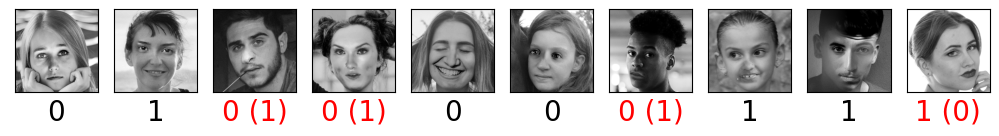

In [18]:
sigmoid = nn.Sigmoid()
x_test, y_test = next(iter(test_data_loader))
transform_ = transforms.Resize(size = (30,30))
x_t = transform_(x_test)
y_pred = model(x_t.squeeze().view(10,-1))
y_test = y_test.numpy().astype(int)
y_pred = torch.round(sigmoid(y_pred)).squeeze(1).detach().numpy().astype(int)
x_test = x_test.squeeze().numpy()
plot_images(x_test, y_test, range(0,10), columns=12, x_size=1, y_size=1, y_pred=y_pred)

In [35]:
x_t.shape

torch.Size([10, 1, 30, 30])

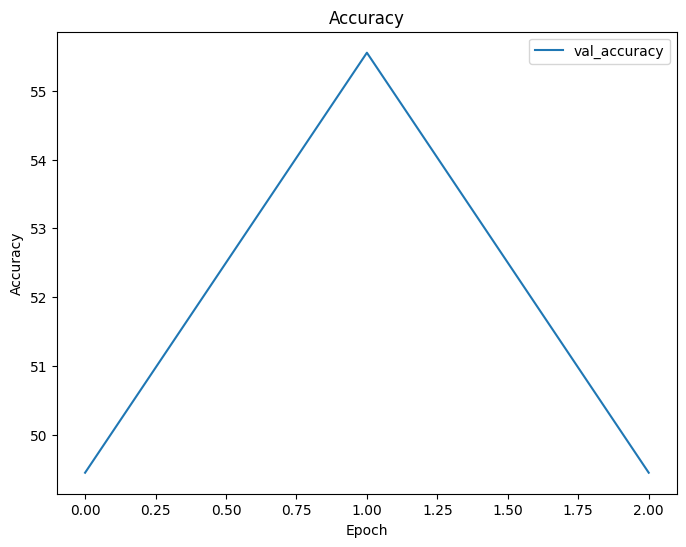

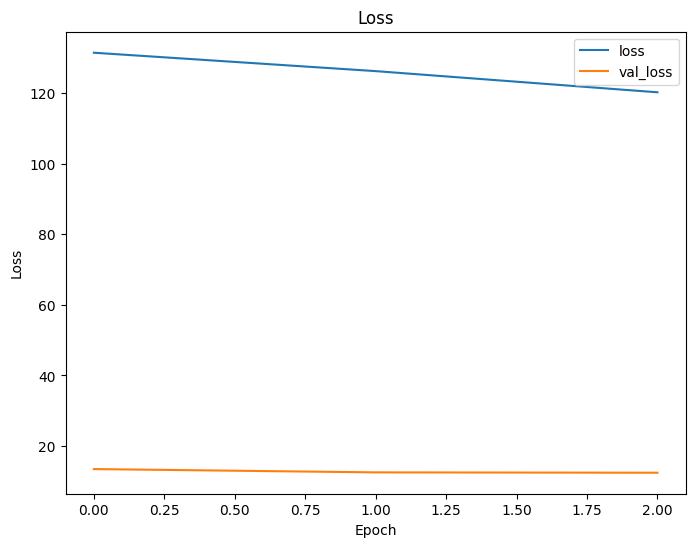

In [19]:
plot_history(history)

In [87]:
def extract_mlp_layer(model, data_loader, len_dataset):
    images_tot = torch.empty((len_dataset, 100), dtype=torch.float)
    labels_im_tot = torch.empty(len_dataset, dtype=torch.float)
    transform = transforms.Resize(size = (30,30))
    model.to("cpu")
    model.eval()
    with torch.no_grad():
        for ib, (images, labels) in enumerate(data_loader):
            indices_b = torch.arange(ib*batch_size, (ib+1)*batch_size)
            #print(indices_b, labels.shape)
            labels_im_tot[indices_b] = labels.float()
            images = transform(images)
            images = images.reshape(images.shape[0], -1)
            out = model(images)
            in_im_vec = activation["hidden3"].reshape(batch_size, -1)
            images_tot[indices_b, :] = in_im_vec

    images_tot = images_tot.numpy()
    labels_im_tot = labels_im_tot.numpy()
    print('Size of vectorized input images:', images_tot.shape)
    print('Size of the tensor storing labels:', labels_im_tot.shape)
    return images_tot, labels_im_tot

In [ ]:
activation = {}
mlp_layer = model.hidden3.register_forward_hook(getActivation('hidden3'))

In [35]:
batch_size=32
X, y = extract_mlp_layer(model, train_data_loader, len(train_dataset))

Size of vectorized input images: (2939, 100)
Size of the tensor storing labels: (2939,)


In [42]:
X = TSNE(perplexity=45,n_components=2, init='pca', learning_rate='auto').fit_transform(X)

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


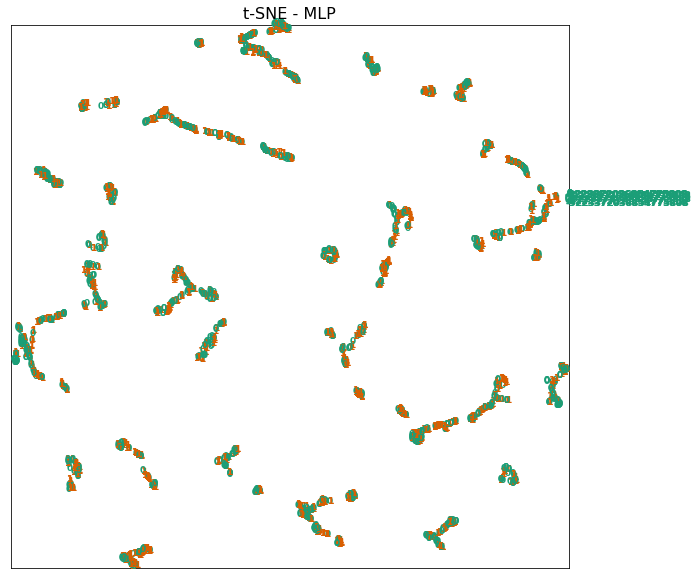

In [43]:
plot_embeddings(X, y, "MLP")

In [50]:
class CNN(nn.Module):
    def __init__(self, num_channels1=16, num_channels2=32, num_classes=1):
        super(CNN, self).__init__()
        self.conv_block1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels= num_channels1, kernel_size=5, padding=2),
                           nn.ReLU(),
                           #nn.BatchNorm2d(num_channels1, affine=False),
                           nn.MaxPool2d(kernel_size=2))
        
        self.conv_block2 = nn.Sequential(nn.Conv2d(num_channels1, num_channels2, kernel_size=5, padding=2),
                           nn.ReLU(),
                           #nn.BatchNorm2d(num_channels2,affine=False),
                           nn.MaxPool2d(kernel_size=2))
        self.fc = nn.Linear(32*7*7, num_classes)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        out = self.fc(x.view(-1, 32*7*7))
        return out

In [51]:
cnn_model = CNN()
cnn_model = cnn_model.cuda()
print(next(cnn_model.parameters()).is_cuda)

True


In [81]:
def training_cnn_classifier(model, train_dataloader, valid_dataloader, num_epochs,
                            loss_fn, learning_rate, verbose=True):

    model_tr = copy.deepcopy(model)
    model_tr = model_tr.to(device)
    
    model_tr.train()
    optimizer = torch.optim.SGD(model_tr.parameters(), lr=learning_rate)
    scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    # Initialize a list to record the training loss over epochs
    loss_all_epochs = []
    valid_acc, valid_loss = [], []
    transform = transforms.Resize(size = (30,30))
    # Training loop
    for epoch in range(num_epochs):
        # Initialize the training loss for the current epoch
        loss_current_epoch = 0
        
        # Iterate over batches using the dataloader
        for batch_index, (images, labels) in enumerate(train_dataloader):
            images = transform(images).to(device)
            labels = labels.to(device)
            y_pred = model_tr(images)
            l = loss_fn(y_pred, labels.view(-1, 1))
            optimizer.zero_grad()
            l.backward()
            loss_current_epoch += l.item()
            optimizer.step() #update parameters

        
        scheduler.step() # Update the learning rate
        loss_all_epochs.append(loss_current_epoch)
        val_loss, accuracy = eval_cnn_classifier(model_tr, 
                                                 valid_dataloader,
                                                 loss_fn)
        valid_loss.append(val_loss)
        valid_acc.append(accuracy)
        if verbose:
            # print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss_current_epoch))
            print(f"\nEpoch [{epoch+1}/{num_epochs}]"
                  f"\nTrain loss: {loss_current_epoch:.5f} | "
                  f"Test loss: {val_loss:.5f} | Test acc: {accuracy:.2f}%\n")
        
    return model_tr, {'loss': loss_all_epochs,'val_loss': valid_loss, 'val_accuracy': valid_acc}

def eval_cnn_classifier(model, eval_dataloader,loss_fn):
    sigmoid = nn.Sigmoid()
    # Set the model in evaluation mode
    model.eval() 
    transform = transforms.Resize(size = (30,30))
    # In test phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        # initialize the total and correct number of labels to compute the accuracy
        correct,loss = 0, 0
        total = 0
        for images, labels in eval_dataloader:
            images = transform(images).to(device)
            labels = labels.to(device)
            y_predicted = model(images)
            label_predicted = torch.round(sigmoid(y_predicted)).squeeze(1) #y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
            l =loss_fn(y_predicted, labels.unsqueeze(1).to(device))
            loss += l.item()
            total += labels.size(0)
            correct += (label_predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    
    return loss, accuracy

In [83]:
model_cnn = CNN()
model_cnn.to(device)
num_epochs = 20
learning_rate = 0.3
loss_fn = nn.BCEWithLogitsLoss()
model_cnn, history= training_cnn_classifier(model_cnn, train_data_loader,valid_data_loader, num_epochs,
                            loss_fn, learning_rate, verbose=True)


Epoch [1/20]
Train loss: 204.59577 | Test loss: 22.14239 | Test acc: 54.06%


Epoch [2/20]
Train loss: 202.45621 | Test loss: 22.13193 | Test acc: 54.69%


Epoch [3/20]
Train loss: 201.31711 | Test loss: 20.79536 | Test acc: 60.62%


Epoch [4/20]
Train loss: 196.31074 | Test loss: 21.05559 | Test acc: 61.25%


Epoch [5/20]
Train loss: 193.26314 | Test loss: 20.15262 | Test acc: 66.56%


Epoch [6/20]
Train loss: 189.97530 | Test loss: 20.95505 | Test acc: 61.88%


Epoch [7/20]
Train loss: 183.94323 | Test loss: 20.26340 | Test acc: 65.31%


Epoch [8/20]
Train loss: 175.68937 | Test loss: 19.54860 | Test acc: 64.38%


Epoch [9/20]
Train loss: 168.69371 | Test loss: 20.05013 | Test acc: 65.31%


Epoch [10/20]
Train loss: 159.67811 | Test loss: 18.87703 | Test acc: 67.19%


Epoch [11/20]
Train loss: 149.75975 | Test loss: 19.03245 | Test acc: 69.06%


Epoch [12/20]
Train loss: 138.71797 | Test loss: 18.41023 | Test acc: 69.69%


Epoch [13/20]
Train loss: 124.60076 | Test loss: 18.03307 | 

val_accuracy [54.0625, 54.6875, 60.625, 61.25, 66.5625, 61.875, 65.3125, 64.375, 65.3125, 67.1875, 69.0625, 69.6875, 73.4375, 74.0625, 75.625, 76.25, 75.9375, 77.8125, 78.4375, 80.9375]


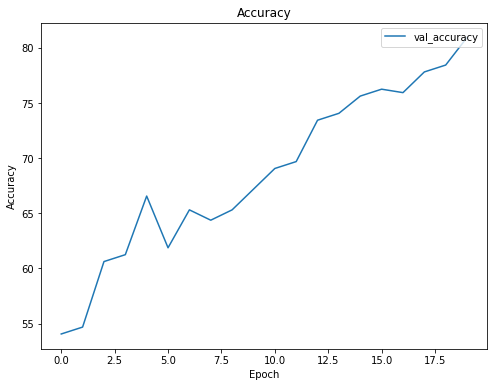

loss [204.59577351808548, 202.45620888471603, 201.3171083331108, 196.3107390999794, 193.26314216852188, 189.97529888153076, 183.9432298541069, 175.6893700659275, 168.69371098279953, 159.67811389267445, 149.75975246727467, 138.71797351539135, 124.60075996816158, 114.3598038032651, 101.01719273626804, 87.24475003406405, 77.05255727097392, 64.9881448931992, 54.8913813456893, 46.44112681411207]
val_loss [22.142387866973877, 22.13192844390869, 20.795357525348663, 21.055585026741028, 20.152617752552032, 20.955052137374878, 20.26340162754059, 19.548600524663925, 20.050133049488068, 18.877025842666626, 19.032451540231705, 18.410228565335274, 18.0330673456192, 19.255953207612038, 17.864332631230354, 16.756149761378765, 16.507662922143936, 18.487866029143333, 17.91882161051035, 15.640864919871092]


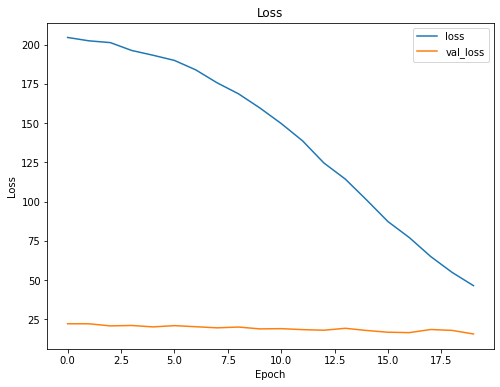

In [86]:
plot_history(history)

In [ ]:
model_cnn = CNN()
model_cnn.to(device)
num_epochs = 50
learning_rate = 0.25
loss_fn = nn.BCEWithLogitsLoss()
transform_ = transforms.Resize(size = (30,30))
model_cnn.train()
    
    # Define the optimizer
optimizer = torch.optim.SGD(model_cnn.parameters(), lr=learning_rate)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    # Initialize a list to record the training loss over epochs
loss_all_epochs = []
    
    # Training loop
for epoch in range(num_epochs):
        # Initialize the training loss for the current epoch
    loss_current_epoch = 0
        
        # Iterate over batches using the dataloader
    for batch_index, (images, labels) in enumerate(train_data_loader):
        images = transform_(images).to(device)
        print(images.shape)
        labels = labels.to(device)
        y_pred = model_cnn(images)
        l = loss_fn(y_pred, labels.view(-1, 1))
        optimizer.zero_grad()
        l.backward()
        loss_current_epoch += l.item()
        optimizer.step() #update parameters

        # At the end of each epoch, record and display the loss over all batches
    scheduler.step()
    loss_all_epochs.append(loss_current_epoch)
    
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss_current_epoch))

In [36]:
eval_cnn_classifier(model_cnn, valid_data_loader)

89.0625

In [88]:
activation = {}
cnn_layer = model_cnn.conv_block2.register_forward_hook(getActivation('conv_block2'))

In [89]:
batch_size = 10
len_dataset=len(train_data)
transform = transforms.Resize(size = (30,30))
images_tot = torch.empty((len_dataset, 32*49), dtype=torch.float)
labels_im_tot = torch.empty(len_dataset, dtype=torch.float)
model_cnn.to('cpu')
model_cnn.eval()
with torch.no_grad():
    for ib, (images, labels) in enumerate(train_data_loader):
        images = transform(images)
        indices_b = torch.arange(ib*batch_size, (ib+1)*batch_size)
        labels_im_tot[indices_b] = labels.float()
        out = model_cnn(images)
        in_im_vec = activation["conv_block2"].reshape(batch_size, -1)
        images_tot[indices_b, :] = in_im_vec

images_tot = images_tot.numpy()
labels_im_tot = labels_im_tot.numpy()
print('Size of vectorized input images:', images_tot.shape)
print('Size of the tensor storing labels:', labels_im_tot.shape)

Size of vectorized input images: (2939, 1568)
Size of the tensor storing labels: (2939,)


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2593: UserWarning: n_quantiles (1000) is greater than the total number of samples (500). n_quantiles is set to n_samples.
  "n_samples." % (self.n_quantiles, n_samples)


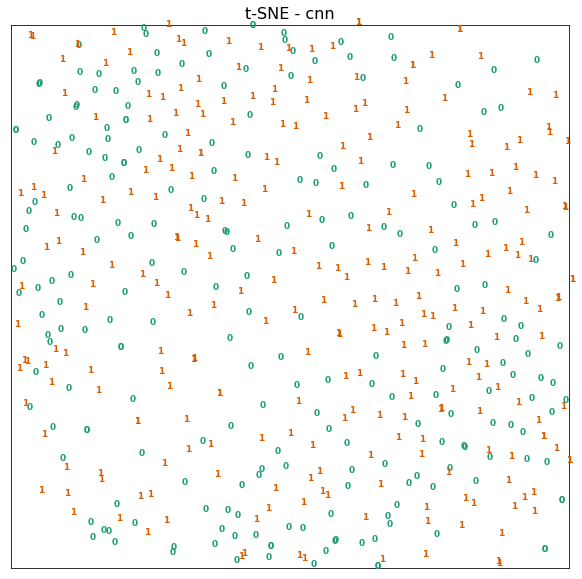

In [95]:
X = TSNE(n_components=2, init='pca', learning_rate='auto',n_iter=2000).fit_transform(images_tot[:500,:])
plot_embeddings(X, labels_im_tot[:500], "cnn")

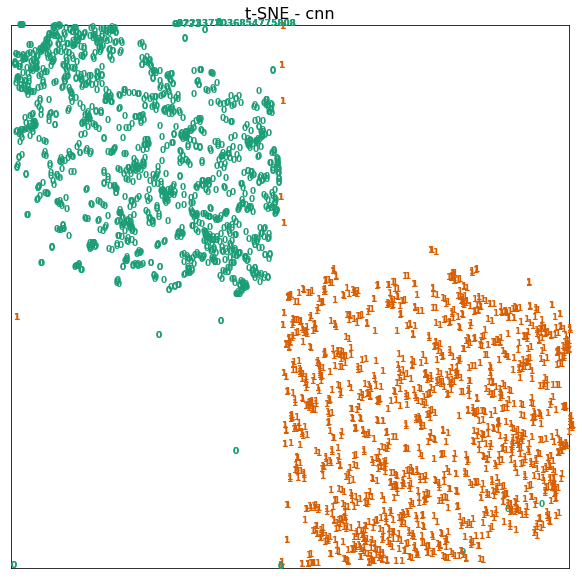

In [129]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(images_tot[:,:],
                                                              y=labels_im_tot[:].astype(int)
                                                             )
plot_embeddings(standard_embedding, labels_im_tot[:], "cnn")

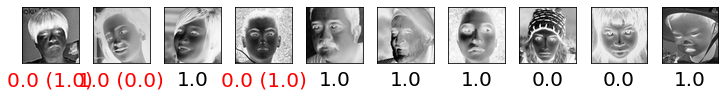

In [173]:
sigmoid = nn.Sigmoid()
x_test, y_test = next(iter(test_data_loader))
transform_ = transforms.Resize(size = (30,30))
x_t = transform_(x_test)
y_pred = model_cnn(x_t)
y_test = y_test.numpy()
y_pred = torch.round(sigmoid(y_pred)).squeeze(1).detach().numpy()
x_test = x_test.squeeze().numpy()
plot_images(x_test, y_test, range(0,10), columns=12, x_size=1, y_size=1, y_pred=y_pred)

In [157]:
def plot_confusion_matrix(y_true,y_pred,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          figsize=(10, 8),
                          digit_format='{:0.2f}'):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    cm = confusion_matrix( y_true,y_pred, normalize=None, labels=target_names)
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, digit_format.format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [174]:
transform_ = transforms.Resize(size = (30,30))
true_labels, pred_labels = [], []
for x, y in test_data_loader:
    x_t = transform_(x)
    y_pred = model_cnn(x_t)
    true_labels += y.tolist()
    prediction = torch.round(sigmoid(y_pred)).squeeze(1).detach().numpy().tolist()
    pred_labels += prediction

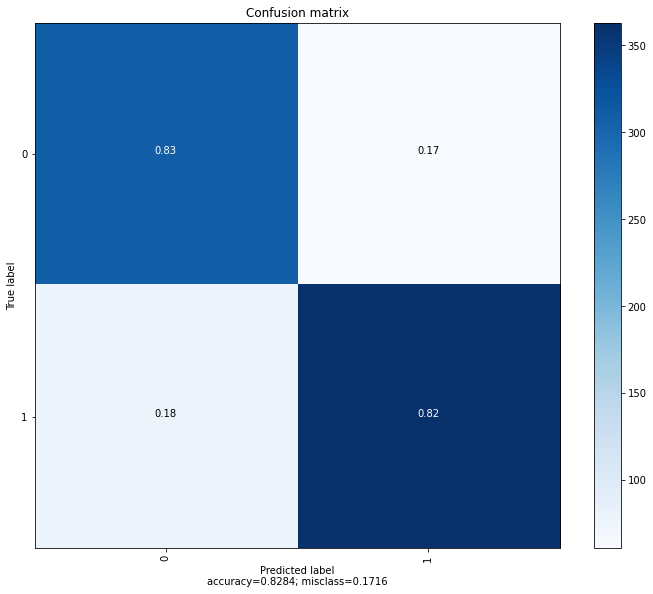

In [175]:
plot_confusion_matrix(y_true=np.array(true_labels),y_pred=np.array(pred_labels),
                          target_names=[0, 1])